# Setup

In [1]:
import pandas as pd
import numpy as np
import random
import networkx as nx
import networkit as nk
import matplotlib.pyplot as plt
import collections
import graph_tool.all as gt
import scipy.sparse as sp
import scipy.stats as ss
import scipy.sparse.csgraph
from scipy.sparse.linalg import eigs
from math import factorial, comb

## Dataset aggregation (only needs to be run once)

In [2]:
# load original dataset

DATASET_PATH = 'rabobank_data.csv'
graph_df = pd.read_csv(DATASET_PATH, sep=';')

In [3]:
# aggregate dataset, removing parallel edges as a result

graph_df = graph_df.groupby(['start_id', 'end_id']).agg({'total':'sum', 'count':'sum', 'year_from':'min', 'year_to':'max'}).reset_index()

In [62]:
# remove temporal information and save as new csv

graph_df = graph_df.drop(['year_from', 'year_to'], axis=1)
graph_df.to_csv('rabobank_data_agg.csv', index=False)

## Graph Loading

In [2]:
DATASET_PATH = 'rabobank_data_agg.csv'
graph_df = pd.read_csv(DATASET_PATH)

In [3]:
graph_df

,start_id,end_id,total,count
0,000000188099d7bd,3efddc7686388b81,3589,3
1,000000188099d7bd,6de37f691c1e32ad,392,5
2,000000188099d7bd,6f4500ea516c88aa,9827,10
3,000000188099d7bd,73d296467d6574f1,16476,38
4,000000188099d7bd,87ab48d52a8c910a,9840,25
...,...,...,...,...
3823162,ffffc4248156da34,75d277cc026cf633,70,17
3823163,ffffc5a2829ba195,77eddfa76b8f71d5,10,1
3823164,ffffcd331ca54184,15d799a263aab3b2,19026,14
3823165,ffffd41fed23ebdd,ea594f85d91467ea,60,1


### NetworKit

In [73]:
def get_graph_nk():
    '''Loads a .gt format file to a networkit graph, returns the largest weakly connected component of the graph'''
    g_cc = nk.readGraph('g_cc.gt', nk.Format.GraphToolBinary)
    cc_nodes = max(nk.components.WeaklyConnectedComponents(g_cc).run().getComponents(), key=len)
    to_remove = list(set([n for n in g_cc.iterNodes()]) - set(cc_nodes))
    for node in to_remove:
        g_cc.removeNode(node)
    return g_cc

In [3]:
def get_graph_nk_rewire():
    '''Loads a .gt format file corresponding to a rewired graph'''
    g_cc = nk.readGraph('g_cc_rewire.gt', nk.Format.GraphToolBinary)
    return g_cc

### NetworkX

In [3]:
# Create DiGraph using graph dataframe, delete dataframe afterwards for memory

G = nx.from_pandas_edgelist(graph_df,
                            source='start_id',
                            target='end_id',
                            edge_attr=['count', 'total'],
                            create_using=nx.DiGraph())
del graph_df

In [4]:
# Retrieve largest weakly connected component of G

largest_cc = max(nx.weakly_connected_components(G), key=len)
G_cc = G.subgraph(largest_cc).copy()
del G
del largest_cc

### Graph-Tool

In [4]:
def get_graph():
    '''Load graph dataset, extracting largest weakly connected component'''
    options = {
        'delimiter': ',',
        'quotechar': '"',
    }
    g = gt.load_graph_from_csv('rabobank_data_agg.csv', csv_options=options, directed=True, ecols=(0,1))
    g_cc = gt.extract_largest_component(g, directed=False)
    return g_cc

In [5]:
# save g_cc to .gt format

g_cc = get_graph()
g_cc.save('g_cc.gt', fmt='gt')

# Analysis

## Assortativity and Clustering

In [12]:
nx.degree_assortativity_coefficient(G_cc)

-0.08270930612732405

In [13]:
nx.average_clustering(G_cc)

0.016559620451334172

In [14]:
nx.average_clustering(G_cc.to_undirected())

0.019922713905292773

In [15]:
nx.transitivity(G_cc)

0.0012160172795731175

In [16]:
nx.transitivity(G_cc.to_undirected())

0.0010559823104946378

## in-out degree plot

In [19]:
in_degrees = np.array([G_cc.in_degree(node) for node in G_cc.nodes])
out_degrees = np.array([G_cc.out_degree(node) for node in G_cc.nodes])

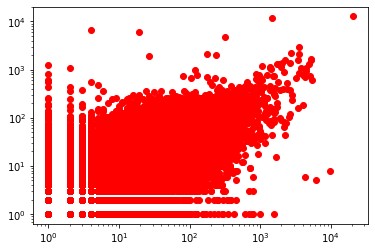

In [20]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(in_degrees, out_degrees, 'o', color='r')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

## in/out-degree cdf

In [21]:
total_nodes = G_cc.number_of_nodes()

in_counter = collections.Counter([d for n, d in G_cc.in_degree()])
in_counter = sorted(in_counter.items())
in_degrees = [d[0] for d in in_counter][:-1]
in_freq = np.cumsum([d[1] / total_nodes for d in in_counter])
in_freq = [1 - f for f in in_freq][:-1]

out_counter = collections.Counter([d for n, d in G_cc.out_degree()])
out_counter = sorted(out_counter.items())
out_degrees = [d[0] for d in out_counter][:-1]
out_freq = np.cumsum([d[1] / total_nodes for d in out_counter])
out_freq = [1 - f for f in out_freq][:-1]


In [22]:
# computing Erdős–Rényi in degree distributions
avg_in = np.average([d for n, d in G_cc.in_degree()])
N = total_nodes
p = avg_in / N
erdos_distr = [ comb(N - 1, k) * p**k * (1 - p)**(N - 1 - k) for k in range(13) ]

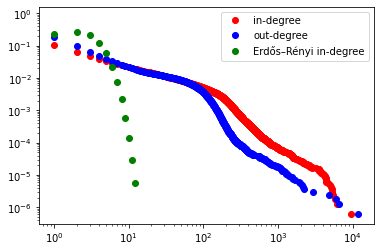

In [23]:
# plot in and out degree CDFs, comparing to the Erdős–Rényi in degree distribution

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(in_degrees, in_freq, 'o', color='r', label='in-degree')
ax.plot(out_degrees, out_freq, 'o', color='b', label='out-degree')
ax.plot([i for i in range(13)], erdos_distr, 'o', color='g', label='Erdős–Rényi in-degree')
ax.legend(loc="upper right")
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

## edge weight cdf

In [24]:
edge_data = [e for e in G_cc.edges.data()]

In [25]:
total_edges = len(edge_data)

In [26]:
# get CDF for 'total' strength
GT_str_counter = collections.Counter([edge[2]['total'] for edge in edge_data])
GT_str_counter = sorted(GT_str_counter.items())
GT_str_weight = [d[0] for d in GT_str_counter]
GT_str_freq = np.cumsum([d[1] / total_edges for d in GT_str_counter])
GT_str_freq = [1 - f for f in GT_str_freq]

# get CDF for 'count' strength
GN_str_counter = collections.Counter([edge[2]['count'] for edge in edge_data])
GN_str_counter = sorted(GN_str_counter.items())
GN_str_weight = [d[0] for d in GN_str_counter]
GN_str_freq = np.cumsum([d[1] / total_edges for d in GN_str_counter])
GN_str_freq = [1 - f for f in GN_str_freq]

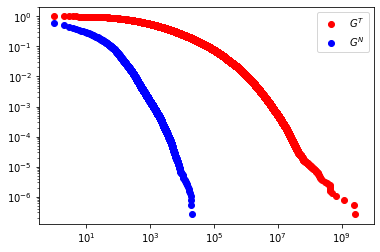

In [27]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(GT_str_weight, GT_str_freq, 'o', color='r', label='$G^T$')
ax.plot(GN_str_weight, GN_str_freq, 'o', color='b', label='$G^N$')
ax.legend(loc="upper right")
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

## node strength cdf

In [28]:
# get CDF for 'total' in-strength
GT_in_counter = collections.Counter([d for n, d in G_cc.in_degree(weight='total')])
GT_in_counter = sorted(GT_in_counter.items())
GT_in_degrees = [d[0] for d in GT_in_counter][:-1]
GT_in_freq = np.cumsum([d[1] / total_nodes for d in GT_in_counter])
GT_in_freq = [1 - f for f in GT_in_freq][:-1]

# get CDF for 'total' out-strength
GT_out_counter = collections.Counter([d for n, d in G_cc.out_degree(weight='total')])
GT_out_counter = sorted(GT_out_counter.items())
GT_out_degrees = [d[0] for d in GT_out_counter][:-1]
GT_out_freq = np.cumsum([d[1] / total_nodes for d in GT_out_counter])
GT_out_freq = [1 - f for f in GT_out_freq][:-1]

# get CDF for 'count' in-strength
GN_in_counter = collections.Counter([d for n, d in G_cc.in_degree(weight='count')])
GN_in_counter = sorted(GN_in_counter.items())
GN_in_degrees = [d[0] for d in GN_in_counter][:-1]
GN_in_freq = np.cumsum([d[1] / total_nodes for d in GN_in_counter])
GN_in_freq = [1 - f for f in GN_in_freq][:-1]

# get CDF for 'count' out-strength
GN_out_counter = collections.Counter([d for n, d in G_cc.out_degree(weight='count')])
GN_out_counter = sorted(GN_out_counter.items())
GN_out_degrees = [d[0] for d in GN_out_counter][:-1]
GN_out_freq = np.cumsum([d[1] / total_nodes for d in GN_out_counter])
GN_out_freq = [1 - f for f in GN_out_freq][:-1]

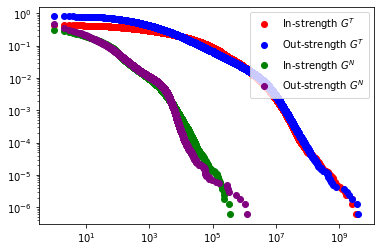

In [29]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(GT_in_degrees, GT_in_freq, 'o', color='r', label='In-strength $G^T$')
ax.plot(GT_out_degrees, GT_out_freq, 'o', color='b', label='Out-strength $G^T$')
ax.plot(GN_in_degrees, GN_in_freq, 'o', color='g', label='In-strength $G^N$')
ax.plot(GN_out_degrees, GN_out_freq, 'o', color='purple', label='Out-strength $G^N$')
ax.legend(loc="upper right")
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

## Strength vs Degree

In [60]:
# get strengths and degree of each node

GT_strengths = [s for v, s in G_cc.degree(weight='total')]
GN_strengths = [s for v, s in G_cc.degree(weight='count')]
degrees = [d for v, d in G_cc.degree()]

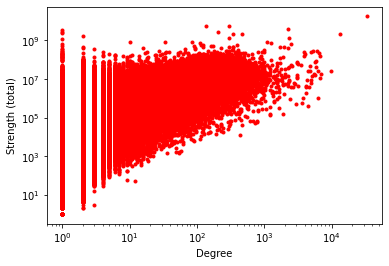

In [67]:
# degree vs 'total' strength plot

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(degrees, GT_strengths, '.', color='r', label='$G^T$')
#ax.legend(loc="upper right")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('Strength (total)')
plt.show()

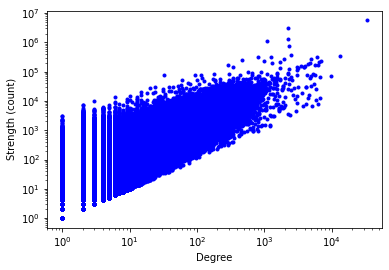

In [68]:
# degree vs 'count' strength plot

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(degrees, GN_strengths, '.', color='b', label='$G^N$')
#ax.legend(loc="upper right")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Degree')
ax.set_ylabel('Strength (count)')
plt.show()

In [63]:
scipy.stats.spearmanr(degrees, GT_strengths)

SpearmanrResult(correlation=0.5711735067755702, pvalue=0.0)

In [69]:
scipy.stats.spearmanr(degrees, GN_strengths)

SpearmanrResult(correlation=0.6481431619382767, pvalue=0.0)

## Total vs Count

In [72]:
edge_data = [e for e in G_cc.edges.data()]
counts = [e[2]['count'] for e in edge_data]
totals= [e[2]['total'] for e in edge_data]

In [ ]:
fig = plt.figure(dpi=1200)
ax = fig.add_subplot(1, 1, 1)
ax.plot(totals, counts, '.', color='0')
#ax.legend(loc="upper right")
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Total')
ax.set_ylabel('Count')
plt.savefig('count_vs_total.png')
plt.show()

In [75]:
# spearman rank correlation coefficient, total vs count

scipy.stats.spearmanr(totals, counts)

SpearmanrResult(correlation=0.7299619627894224, pvalue=0.0)

## Robustness Testing

## Rewiring

### Rewired Error Robustness

In [4]:
g_cc = get_graph()

In [5]:
def rand_attack(target, vertices, delta_x=1620):
    '''
    Returns the average finite cluster size of the graph after removing delta_x nodes
    
    Parameters:
    target (gt.Graph): Target graph to attack
    vertices (list of gt.Vertex): Vertices of target, the first delta_x of which will be removed from target and the list itself
    delta_x (int): The number of nodes to remove
    
    Returns:
    int: The resulting average finite cluster size of target after node removal
    '''
    to_delete = vertices[:delta_x]
    target.remove_vertex(to_delete, fast=True)
    del vertices[:delta_x]
    return avg_size(target)


def avg_size(target):
    '''
    Returns the average finite cluster size of the target graph
    
    Parameters:
    target (gt.Graph): Graph to compute average finite cluster size of
    
    Returns:
    int: The average finite cluster size of target
    '''
    total_nodes = len(list(target.get_vertices()))
    _, hist = gt.label_components(target, directed=False)
    hist = np.sort(hist)[:-1]
    numerator = np.sum(np.power(hist, 2) / total_nodes)
    denominator = np.sum(hist / total_nodes)
    return numerator / denominator


def get_nodes(target):
    '''
    Returns the nodes of a graph in a random order
    
    Parameters:
    target (gt.Graph): Graph to get nodes from
    
    Returns:
    list of gt.Vertex: The nodes of target
    '''
    vertices = [v for v in target.get_vertices()]
    np.random.shuffle(vertices)
    return vertices


def approx_area(sizes):
    '''
    Computes the R-Index of an attack
    
    Parameters:
    sizes (list of int): Normalized largest weakly connected component size after each node removal
    
    Returns:
    int: R-Index of the corresponding attack
    '''
    return sum(sizes) / (len(sizes) + 1)

In [16]:
# Perform random attack on original graph and rewired graph

sizes, _ = gt.vertex_percolation(g_cc, get_nodes(g_cc))
gt.random_rewire(g_cc, n_iter=2)
sizes_rewire, _ = gt.vertex_percolation(g_cc, get_nodes(g_cc))

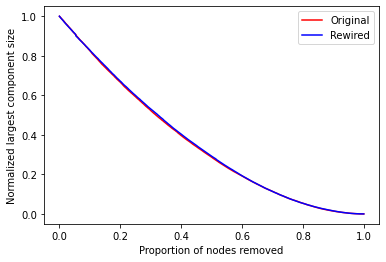

In [17]:
nodes_removed = [i / 1622173 for i in range(1622173)]
sizes = sizes[::-1]
sizes = [size / 1622173 for size in sizes]
max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
sizes_rewire = sizes_rewire[::-1]
sizes_rewire = [size / max_size_rewire for size in sizes_rewire]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, sizes_rewire, color='b', label='Rewired')
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [18]:
print(f'APPROX AREA REAL: {approx_area(sizes)}')
print(f'APPROX AREA REWIRE: {approx_area(sizes_rewire)}')

APPROX AREA REAL: 0.3555436073942095
APPROX AREA REWIRE: 0.3585942155642629


In [17]:
indices = []
indices_rewire = []
NUM_RUNS = 100

# get R-indices of 100 random attacks on original network
g_cc = get_graph()
for run in range(NUM_RUNS):
    sizes, _ = gt.vertex_percolation(g_cc, get_nodes(g_cc))
    sizes = [size / 1622173 for size in sizes]
    indices.append(approx_area(sizes))

In [18]:
# get R-indices of 100 random attacks on rewired networks
for run in range(NUM_RUNS):
    gt.random_rewire(g_cc, n_iter=2)
    sizes_rewire, _ = gt.vertex_percolation(g_cc, get_nodes(g_cc))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes_rewire = [size / max_size_rewire for size in sizes_rewire]
    indices_rewire.append(approx_area(sizes_rewire))

In [7]:
print(f'AVG R-INDEX REAL: {np.average(indices)}')
print(f'AVG R-INDEX REWIRE: {np.average(indices_rewire)}')

AVG R-INDEX REAL: 0.3598084835452147
AVG R-INDEX REWIRE: 0.35985230718251804


In [19]:
print(f'STD R-INDEX REAL: {np.std(indices)}')
print(f'STD R-INDEX REWIRE: {np.std(indices_rewire)}')

STD R-INDEX REAL: 0.001793501377374081
STD R-INDEX REWIRE: 0.00155413765063896


In [8]:
# Kolmogorov-Smirnov test on original and rewired R-indices

scipy.stats.ks_2samp(indices, indices_rewire)

KstestResult(statistic=0.07, pvalue=0.9684099261397212)

In [ ]:
# get finite cluster sizes corresponding to random attack on original network

g_cc = get_graph()
avg_sizes = []

NUM_RUNS = 1000
for run in range(NUM_RUNS):
    length = rand_attack(g_cc, get_nodes(g_cc))
    avg_sizes.append(length)

In [ ]:
# get finite cluster sizes corresponding to random attacks on 20 rewired networks

run_lengths = np.empty((0, 1000))
g_cc = get_graph()

for rewiring in range(20):
    g_cc = get_graph()
    gt.random_rewire(g_cc)
    print(f'REWIRE {rewiring}')
    lengths = []

    NUM_RUNS = 1000
    for run in range(NUM_RUNS):
        length = rand_attack(g_cc, get_nodes(g_cc))
        lengths.append(length)
    run_lengths = np.vstack((run_lengths, lengths))


In [20]:
size_avg = np.average(run_lengths, axis=0)
size_std = np.std(run_lengths, axis=0)

In [22]:
# normalize original and rewired aggregate finite cluster sizes

size_avg -= np.min(size_avg)
min_size = np.min(avg_sizes)
avg_sizes = [size - min_size for size in avg_sizes]

size_std = size_std / np.max(size_std)
size_avg = size_avg / np.max(size_avg)
max_size = np.max(avg_sizes)
avg_sizes = [size / max_size for size in avg_sizes]

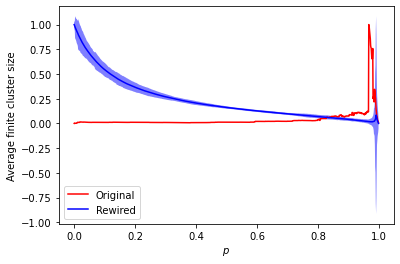

In [25]:
nodes_removed = [i * 1620 / 1622713 for i in range(1000)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, avg_sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + size_std, size_avg - size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="lower left")
ax.set_xlabel('$p$')
ax.set_ylabel('Average finite cluster size')
plt.show()

### Rewired Deg Attack

In [20]:
g_cc = get_graph()

In [21]:
vertices_by_degree = sorted([v for v in g_cc.vertices()], key=lambda v: v.out_degree() + v.in_degree())

In [22]:
sizes, comp = gt.vertex_percolation(g_cc, vertices_by_degree)

In [38]:
sizes = [size / 1622173 for size in sizes]
approx_area(sizes)

0.005065257283296363

In [12]:
def deg_attack(target, vertices, delta_x=1620):
    most_connected_nodes = vertices[:delta_x]
    target.remove_vertex(most_connected_nodes, fast=True)
    del vertices[:delta_x]
    return avg_size(target)


def avg_size(target):
    total_nodes = len(list(target.get_vertices()))
    _, hist = gt.label_components(target, directed=False)
    hist = np.sort(hist)[:-1]
    numerator = np.sum(np.power(hist, 2) / total_nodes)
    denominator = np.sum(hist / total_nodes)
    return numerator / denominator


def approx_area(sizes):
    return sum(sizes) / (len(sizes) + 1)

In [30]:
avg_sizes = []
g_cc = get_graph()

NUM_RUNS = 100
vertices_by_degree = sorted([v for v in g_cc.vertices()], key=lambda v: v.out_degree() + v.in_degree(), reverse=True)
for run in range(NUM_RUNS):
    length = deg_attack(g_cc, vertices_by_degree)
    avg_sizes.append(length)
    vertices_by_degree = sorted([v for v in g_cc.vertices()], key=lambda v: v.out_degree() + v.in_degree(), reverse=True)

In [ ]:
run_lengths = np.empty((0, 100))
g_cc = get_graph()

for rewiring in range(100):
    g_cc = get_graph()
    gt.random_rewire(g_cc)
    print(f'REWIRE {rewiring}')
    lengths = []

    NUM_RUNS = 100
    vertices_by_degree = sorted([v for v in g_cc.vertices()], key=lambda v: v.out_degree() + v.in_degree(), reverse=True)
    for run in range(NUM_RUNS):
        length = deg_attack(g_cc, vertices_by_degree)
        lengths.append(length)
        vertices_by_degree = sorted([v for v in g_cc.vertices()], key=lambda v: v.out_degree() + v.in_degree(), reverse=True)
    run_lengths = np.vstack((run_lengths, lengths))


In [25]:
size_avg = np.average(run_lengths, axis=0)
size_std = np.std(run_lengths, axis=0)

In [ ]:
size_avg -= np.min(size_avg)
min_size = np.min(avg_sizes)
avg_sizes = [size - min_size for size in avg_sizes]

In [ ]:
size_std = size_std / np.max(size_std)
size_avg = size_avg / np.max(size_avg)
max_size = np.max(avg_sizes)
avg_sizes = [size / max_size for size in avg_sizes]

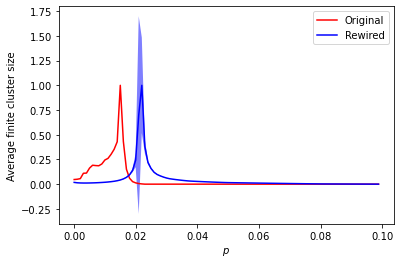

In [41]:
nodes_removed = [i * 1620 / 1622713 for i in range(100)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, avg_sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + size_std, size_avg - size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('$p$')
ax.set_ylabel('Average finite cluster size')
plt.show()

In [35]:
r_indices = []
run_sizes = np.empty((0, 1622173))
g_cc = get_graph()

for run in range(100):
    gt.random_rewire(g_cc, n_iter=2)
    influential_nodes = sorted([v for v in g_cc.vertices()], key=lambda v: v.out_degree() + v.in_degree())
    sizes, _ = gt.vertex_percolation(g_cc, influential_nodes)
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))

In [ ]:
print(np.average(r_indices))
print(np.std(r_indices))

In [37]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

In [40]:
g_cc = get_graph()
sizes, _ = gt.vertex_percolation(g_cc, sorted([v for v in g_cc.vertices()], key=lambda v: v.out_degree() + v.in_degree()))

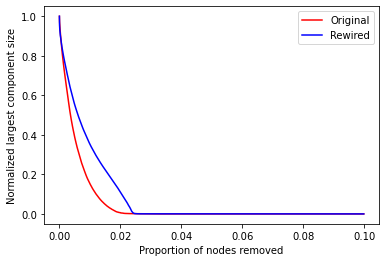

In [46]:
nodes_removed = [i / 1622173 for i in range(162000)]
sizes = sizes[::-1][:162000]
sizes = [size / 1622173 for size in sizes]
print(approx_area(sizes))
size_avg = size_avg[::-1][:162000]
size_std = size_std[::-1][:162000]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + size_std, size_avg - size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [60]:
np.average(r_indices)

0.008341217898962023

In [39]:
np.std(r_indices)

1.2779432537023214e-05

In [34]:
kernel = scipy.stats.gaussian_kde(r_indices)

In [39]:
kernel.integrate_box_1d(-np.inf, 0.005065257283296363)

0.0

#### Eigenvector

In [10]:
g_cc = get_graph()
A = gt.adjacency(g_cc)
del g_cc
G_cc = nx.from_numpy_matrix(A, create_using=nx.MultiDiGraph)
del A

In [3]:
def eig_attack(target, vertices, delta_x=1620):
    to_delete = vertices[:delta_x]
    target.remove_vertex(to_delete, fast=True)
    del vertices[:delta_x]
    return compute_xi(target)


def avg_size(G):
    total_nodes = len(G.nodes())
    components = [len(c) for c in sorted(nx.weakly_connected_components(G), key=len, reverse=True)][1:]
    numerator = sum([cc ** 2 / total_nodes for cc in components])
    denominator = sum([cc / total_nodes for cc in components])
    return numerator / denominator


def eig_attack_avg(target, centralities, delta_x=1620):
    most_influential = centralities[:delta_x]
    target.remove_nodes_from(most_influential)
    del centralities[:delta_x]
    return avg_size(target)


def get_influential_nodes(target, reverse=True):
    _, eigen_centralities = gt.eigenvector(g_cc)
    return sorted([i for i in range(len(target.get_vertices()))], key = lambda v: eigen_centralities[v], reverse=reverse)


In [11]:
eigenvector_centrality = nx.eigenvector_centrality_numpy(G_cc)

In [12]:
eigenvector_centrality = list(map(lambda x: x[0], sorted(eigenvector_centrality.items(), key = lambda k : k[1], reverse=True)))
avg_sizes = []
max_size = len(G_cc.nodes())

NUM_RUNS = 1000
for run in range(NUM_RUNS):
    avg_sizes.append(eig_attack_avg(G_cc, eigenvector_centrality))

In [ ]:
run_lengths = np.empty((0, 1000))

for rewiring in range(20):
    g_cc = get_graph()
    gt.random_rewire(g_cc)
    A = gt.adjacency(g_cc)
    g_cc = nx.from_numpy_matrix(A, create_using=nx.DiGraph)
    del A
    print(f'REWIRE {rewiring}')
    lengths = []

    NUM_RUNS = 1000
    eigenvector_centrality = nx.eigenvector_centrality_numpy(g_cc)
    eigenvector_centrality = list(map(lambda x: x[0], sorted(eigenvector_centrality.items(), key = lambda k : k[1], reverse=True)))
    for run in range(NUM_RUNS):
        lengths.append(eig_attack_avg(g_cc, eigenvector_centrality))
    run_lengths = np.vstack((run_lengths, lengths))


In [8]:
size_avg = np.average(run_lengths, axis=0)
size_std = np.std(run_lengths, axis=0)

In [13]:
size_avg -= np.min(size_avg)
min_size = np.min(avg_sizes)
avg_sizes = [size - min_size for size in avg_sizes]

size_std = size_std / np.max(size_std)
size_avg = size_avg / np.max(size_avg)
max_size = np.max(avg_sizes)
avg_sizes = [size / max_size for size in avg_sizes]

In [15]:
size_avg = size_avg[::-1]
size_std = size_std[::-1]
avg_sizes = avg_sizes[::-1]

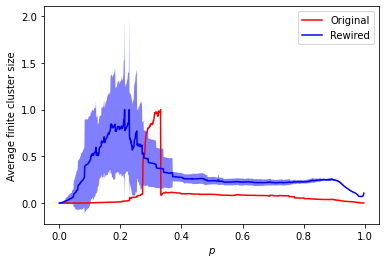

In [16]:
nodes_removed = [i * 1620 / 1622713 for i in range(1000)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, avg_sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + size_std, size_avg - size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('$p$')
ax.set_ylabel('Average finite cluster size')
plt.show()

In [51]:
g_cc = get_graph()

In [33]:
def approx_area(sizes):
    return sum(sizes) / (len(sizes) + 1)

approx_area(sizes)

0.028755939155101766

In [50]:
r_indices = []
run_sizes = np.empty((0, 1622173))
g_cc = get_graph()

for run in range(100):
    gt.random_rewire(g_cc, n_iter=2)
    influential_nodes = get_influential_nodes(g_cc, reverse=False)
    sizes, _ = gt.vertex_percolation(g_cc, influential_nodes)
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))

In [ ]:
g_cc = get_graph()
influential_nodes = get_influential_nodes(g_cc, reverse=False)
sizes, _ = gt.vertex_percolation(g_cc, influential_nodes)

In [54]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

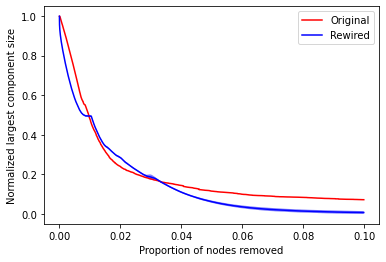

In [60]:
nodes_removed = [i / 1622173 for i in range(162000)]
sizes = sizes[::-1][:162000]
sizes = [size / 1622173 for size in sizes]
print(approx_area(sizes))
size_avg = size_avg[::-1][:162000]
size_std = size_std[::-1][:162000]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [35]:
np.average(r_indices)

0.014539070272986947

In [36]:
np.std(r_indices)

0.0002958396270229017

In [38]:
kernel = scipy.stats.gaussian_kde(r_indices)

In [39]:
kernel.integrate_box_1d(0.028755939155101766, np.inf)

0.0

#### Betweenness

In [40]:
g_cc = get_graph()

In [35]:
def bet_attack(target, vertices, delta_x=1620):
    to_delete = vertices[:delta_x]
    target.remove_vertex(to_delete, fast=True)
    del vertices[:delta_x]
    return avg_size(target)


def avg_size(target):
    total_nodes = len(list(target.get_vertices()))
    _, hist = gt.label_components(target, directed=False)
    hist = np.sort(hist)[:-1]
    numerator = np.sum(np.power(hist, 2) / total_nodes)
    denominator = np.sum(hist / total_nodes)
    return numerator / denominator


def get_influential_nodes(target, reverse=True):
    vertices = [v for v in target.get_vertices()]
    np.random.shuffle(vertices)
    random_vertices = vertices[:1000]
    vertex_betweenness, edge_betweenness = gt.betweenness(target, pivots=random_vertices)
    return sorted([i for i in range(len(target.get_vertices()))], key = lambda v: vertex_betweenness[v], reverse=reverse)


def approx_area(sizes):
    return sum(sizes) / (len(sizes) + 1)


In [41]:
avg_sizes = []

NUM_RUNS = 1000
influential_nodes = get_influential_nodes(g_cc)
print('Betweenness computed, starting attack.')
for run in range(NUM_RUNS):
    length = bet_attack(g_cc, influential_nodes)
    avg_sizes.append(length)
    influential_nodes = get_influential_nodes(g_cc)
    if run % 100 == 99:
        print(f'RUN {run}')

Betweenness computed, starting attack.
RUN 99
RUN 199
RUN 299
RUN 399
RUN 499
RUN 599
RUN 699
RUN 799
RUN 899
RUN 999


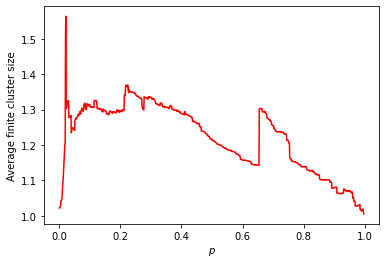

In [66]:
nodes_removed = [i * 1620 / 1622713 for i in range(1000)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, avg_sizes, color='r', label='Original')
ax.set_xlabel('$p$')
ax.set_ylabel('Average finite cluster size')
plt.show()

In [4]:
r_indices = []
run_sizes = np.empty((0, 1622173))
g_cc = get_graph()

for run in range(100):
    gt.random_rewire(g_cc, n_iter=2)
    influential_nodes = get_influential_nodes(g_cc, reverse=False)
    sizes, _ = gt.vertex_percolation(g_cc, influential_nodes)
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')

AVG REWIRED R-INDEX: 0.02265143327345062
STD REWIRED R-INDEX: 0.02265143327345062


In [ ]:
g_cc = get_graph()
influential_nodes = get_influential_nodes(g_cc, reverse=False)
sizes, comp = gt.vertex_percolation(g_cc, influential_nodes)

In [ ]:
run_lengths = np.empty((0, 1000))

for rewiring in range(15):
    g_cc = get_graph()
    gt.random_rewire(g_cc)
    print(f'REWIRE {rewiring}')
    lengths = []

    NUM_RUNS = 1000
    for run in range(NUM_RUNS):
        influential_nodes = get_influential_nodes(g_cc)
        length = bet_attack(g_cc, influential_nodes)
        lengths.append(length)
    run_lengths = np.vstack((run_lengths, lengths))


In [69]:
size_avg = np.average(run_lengths, axis=0)
size_std = np.std(run_lengths, axis=0)

In [70]:
size_avg -= np.min(size_avg)
min_size = np.min(avg_sizes)
avg_sizes = [size - min_size for size in avg_sizes]

size_std = size_std / np.max(size_std)
size_avg = size_avg / np.max(size_avg)
max_size = np.max(avg_sizes)
avg_sizes = [size / max_size for size in avg_sizes]

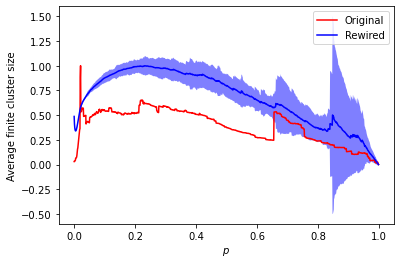

In [71]:
nodes_removed = [i * 1620 / 1622713 for i in range(1000)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, avg_sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + size_std, size_avg - size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('$p$')
ax.set_ylabel('Average finite cluster size')
plt.show()

In [5]:
print(f'STD REWIRED R-INDEX: {np.std(r_indices)}')
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

STD REWIRED R-INDEX: 0.00024876299591328405


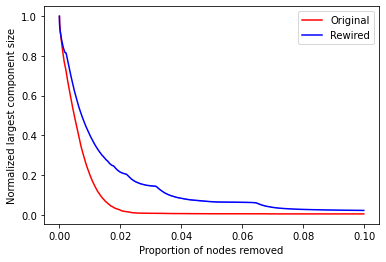

In [8]:
nodes_removed = [i / 1622173 for i in range(162000)]
sizes = sizes[::-1][:162000]
sizes = [size / 1622173 for size in sizes]
print(approx_area(sizes))
size_avg = size_avg[::-1][:162000]
size_std = size_std[::-1][:162000]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [10]:
kernel = scipy.stats.gaussian_kde(r_indices)

In [12]:
kernel.integrate_box_1d(-np.inf, 0.008203812487527516)

0.0

#### Pagerank

In [27]:
g_cc = get_graph()

In [33]:
pageranks = gt.pagerank(g_cc)

In [24]:
def get_influential_nodes(target, reverse=True):
    pageranks = gt.pagerank(target)
    return sorted([i for i in range(len(target.get_vertices()))], key = lambda v: pageranks[v], reverse=reverse)


def page_attack(target, vertices, delta_x=1620):
    to_delete = vertices[:delta_x]
    target.remove_vertex(to_delete, fast=True)
    del vertices[:delta_x]
    return avg_size(target)


def avg_size(target):
    total_nodes = len(list(target.get_vertices()))
    _, hist = gt.label_components(g_cc, directed=False)
    hist = np.sort(hist)[:-1]
    numerator = np.sum(np.power(hist, 2) / total_nodes)
    denominator = np.sum(hist / total_nodes)
    return numerator / denominator

In [ ]:
avg_sizes = []

NUM_RUNS = 100
influential_nodes = get_influential_nodes(g_cc)
print('Pagerank computed, starting attack.')
for run in range(NUM_RUNS):
    length = page_attack(g_cc, influential_nodes)
    avg_sizes.append(length)
    influential_nodes = get_influential_nodes(g_cc)
    if run % 10 == 9:
        print(f'RUN {run}')

In [ ]:
run_lengths = np.empty((0, 100))

for rewiring in range(20):
    g_cc = get_graph()
    gt.random_rewire(g_cc)
    print(f'REWIRE {rewiring}')
    lengths = []

    NUM_RUNS = 100
    for run in range(NUM_RUNS):
        influential_nodes = get_influential_nodes(g_cc)
        length = page_attack(g_cc, influential_nodes)
        lengths.append(length)
    run_lengths = np.vstack((run_lengths, lengths))


In [29]:
size_avg = np.average(run_lengths, axis=0)
size_std = np.std(run_lengths, axis=0)

size_avg -= np.min(size_avg)
min_size = np.min(avg_sizes)
avg_sizes = [size - min_size for size in avg_sizes]

size_std = size_std / np.max(size_std)
size_avg = size_avg / np.max(size_avg)
max_size = np.max(avg_sizes)
avg_sizes = [size / max_size for size in avg_sizes]

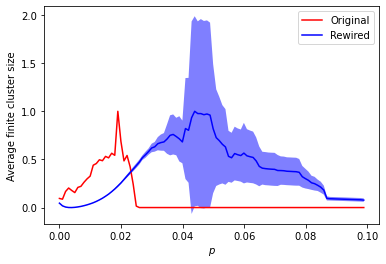

In [31]:
nodes_removed = [i * 1620 / 1622713 for i in range(100)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, avg_sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + size_std, size_avg - size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('$p$')
ax.set_ylabel('Average finite cluster size')
plt.show()

In [17]:
g_cc = get_graph()
influential_nodes = get_influential_nodes(g_cc, reverse=False)
sizes_original, _ = gt.vertex_percolation(g_cc, influential_nodes)

APPROX AREA: 0.006383821787992853


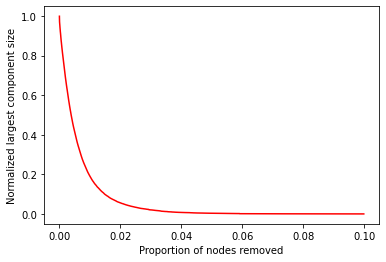

In [27]:
nodes_removed = [i / 1622173 for i in range(162000)]
sizes = [size / 1622173 for size in sizes]
print(f'APPROX AREA: {approx_area(sizes)}')
sizes = sizes[::-1][:162000]
sizes_original = sizes

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r')
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [13]:
r_indices = []
run_sizes = np.empty((0, 1622173))
g_cc = get_graph()

for run in range(100):
    gt.random_rewire(g_cc, n_iter=2)
    influential_nodes = get_influential_nodes(g_cc, reverse=False)
    sizes, _ = gt.vertex_percolation(g_cc, influential_nodes)
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'AVG STD R-INDEX: {np.std(r_indices)}')

AVG REWIRED R-INDEX: 0.010596969589020636
AVG STD R-INDEX: 0.00013303431448973132


In [14]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

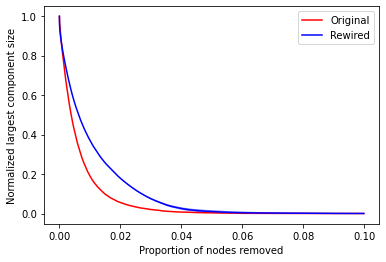

In [18]:
nodes_removed = [i / 1622173 for i in range(162000)]
sizes = sizes_original[::-1][:162000]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1][:162000]
size_std = size_std[::-1][:162000]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [16]:
np.average(r_indices)

0.010588140490316717

In [17]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(-np.inf, 0.006383821787992853)

0.0

#### Closeness

In [83]:
g_cc = get_graph_nk()

In [84]:
closeness = nk.centrality.ApproxCloseness(g_cc, 5000).run()

In [87]:
def close_attack(target, most_influential, delta_x=1620):
    #most_influential = list(map(lambda x: x[0], sorted(centralities.ranking(), key = lambda k : k[1], reverse=True)))[:delta_x]
    for node in most_influential[:delta_x]:
        target.removeNode(node)
    del most_influential[:delta_x]
    return len(max(nk.components.WeaklyConnectedComponents(g_cc).run().getComponents(), key=len))


def close_attack_avg(target, most_influential, delta_x=1620):
    for node in most_influential[:delta_x]:
        target.removeNode(node)
    del most_influential[:delta_x]
    return avg_size(target)
    

def avg_size(target):
    total_nodes = target.numberOfNodes()
    hist = np.array(list(nk.components.DynWeaklyConnectedComponents(g_cc).run().getComponentSizes().values()))
    hist = np.sort(hist)[:-1]
    numerator = np.sum(np.power(hist, 2) / total_nodes)
    denominator = np.sum(hist / total_nodes)
    return numerator / denominator

In [88]:
avg_sizes = []
most_influential = list(map(lambda x: x[0], sorted(closeness.ranking(), key = lambda k : k[1], reverse=True)))

for i in range(1000):
    avg_sizes.append(close_attack_avg(g_cc, most_influential))

In [89]:
avg_sizes = np.array(avg_sizes)

In [90]:
np.save('avg_size_closeness.npy', avg_sizes)

In [ ]:
run_lengths = np.empty((0, 1000))

for rewiring in range(15):
    g_cc = get_graph()
    gt.random_rewire(g_cc, n_iter=2)
    g_cc.save('rewire.gt', fmt='gt')
    g_cc = nk.readGraph('rewire.gt', nk.Format.GraphToolBinary)
    closeness = nk.centrality.ApproxCloseness(g_cc, 5000).run()
    most_influential = list(map(lambda x: x[0], sorted(closeness.ranking(), key = lambda k : k[1], reverse=True)))
    print(f'REWIRE {rewiring}')
    
    lengths = []
    NUM_RUNS = 1000
    for i in range(NUM_RUNS):
        lengths.append(close_attack_avg(g_cc, most_influential))
    run_lengths = np.vstack((run_lengths, lengths))


In [95]:
size_avg = np.average(run_lengths, axis=0)
size_std = np.std(run_lengths, axis=0)

In [96]:
size_avg -= np.min(size_avg)
min_size = np.min(avg_sizes)
avg_sizes = [size - min_size for size in avg_sizes]

size_std = size_std / np.max(size_std)
size_avg = size_avg / np.max(size_avg)
max_size = np.max(avg_sizes)
avg_sizes = [size / max_size for size in avg_sizes]

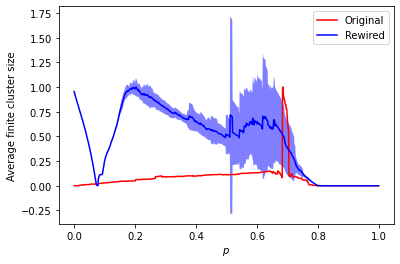

In [97]:
nodes_removed = [i * 1620 / 1622713 for i in range(1000)]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, avg_sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + size_std, size_avg - size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('$p$')
ax.set_ylabel('Average finite cluster size')
plt.show()

In [ ]:
avg_sizes = []

for i in range(100):
    sizes.append(close_attack(g_cc, most_influential))

In [91]:
g_cc = get_graph()
sizes_original, comp = gt.vertex_percolation(g_cc, most_influential)

In [ ]:
g_cc = get_graph_nk()
closeness = nk.centrality.ApproxCloseness(g_cc, 10000).run()
print('CLOSENESS 1 COMPUTED')
most_influential = list(map(lambda x: x[0], sorted(closeness.ranking(), key = lambda k : k[1], reverse=False)))
g_cc = get_graph()
sizes, comp = gt.vertex_percolation(g_cc, most_influential)
print('PERCOLATION FOR REAL NETWORK COMPLETED.')

In [6]:
def approx_area(sizes):
    return sum(sizes) / (len(sizes) + 1)

In [ ]:
r_indices = []
run_sizes = np.empty((0, 1622173))
g_cc = get_graph()

for run in range(100):
    gt.random_rewire(g_cc, n_iter=2)
    g_cc.save('rewire.gt', fmt='gt')
    g_cc = nk.readGraph('rewire.gt', nk.Format.GraphToolBinary)
    closeness = nk.centrality.ApproxCloseness(g_cc, 10000).run()
    most_influential = list(map(lambda x: x[0], sorted(closeness.ranking(), key = lambda k : k[1], reverse=False)))
    g_cc = gt.load_graph('rewire.gt')
    sizes_rewire, _ = gt.vertex_percolation(g_cc, most_influential)
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'AVG STD R-INDEX: {np.std(r_indices)}')

In [ ]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

In [ ]:
nodes_removed = [i / 1622173 for i in range(162000)]
sizes = sizes_original[::-1]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [ ]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(-np.inf, approx_area(sizes))

In [ ]:
print(approx_area(sizes))

### Edge Percolation with Rewiring

#### Random attack

In [19]:
def get_rand_links(target, prop='c0'):
    edges_rand = [(s, t) for s, t, _ in target.iter_edges([target.edge_properties[prop]])]
    np.random.shuffle(edges_rand)
    return edges_rand

In [ ]:
g_cc = get_graph()
num_edges = len(get_rand_links(g_cc))
sizes, _ = gt.edge_percolation(g_cc, get_rand_links(g_cc))

In [ ]:
r_indices = []
r_indices_original = []
run_sizes = np.empty((0, num_edges))
run_sizes_original = np.empty((0, num_edges))

for run in range(50):
    sizes, _ = gt.edge_percolation(g_cc, get_rand_links(g_cc))
    sizes = [size / 1622713 for size in sizes]
    run_sizes_original = np.vstack((run_sizes, sizes))
    r_indices_original.append(approx_area(sizes))

for run in range(50):
    gt.random_rewire(g_cc, n_iter=2)
    sizes, _ = gt.edge_percolation(g_cc, get_rand_links(g_cc))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'STD: {np.std(r_indices)}')

print(f'AVG ORIGINAL R-INDEX: {np.average(r_indices_original)}')
print(f'STD: {np.std(r_indices_original)}')

In [ ]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

size_avg_orig = np.average(run_sizes_original, axis=0)
size_std_orig = np.std(run_sizes_original, axis=0)

In [ ]:
nodes_removed = [i / 1622173 for i in range(num_edges)]
size_avg_orig = size_avg_orig[::-1]
size_std_orig = size_std_orig[::-1]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, size_avg_orig, color='r', label='Original')
ax.fill_between(nodes_removed, size_avg_orig + 2 * size_std_orig, size_avg_orig - 2 * size_std_orig, facecolor='red', alpha=0.5)
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [48]:
scipy.stats.ks_2samp(r_indices_original, r_indices)

KstestResult(statistic=1.0, pvalue=2.2087606931995054e-59)

In [50]:
scipy.stats.ks_2samp(r_indices_original, r_indices, alternative='greater')

KstestResult(statistic=0.0, pvalue=1.0)

#### Strongest link (total)

In [6]:
g_cc = get_graph()

In [3]:
def get_weakest_links(target, prop='c0', reverse=False):
    edge_totals = [(s, t, w) for s, t, w in g_cc.iter_edges([g_cc.edge_properties[prop]])]
    edge_totals = sorted(edge_totals, key=lambda e: int(e[2]), reverse=reverse)
    return [(s,t) for s, t, w in edge_totals]


def approx_area(sizes):
    return sum(sizes) / (len(sizes) + 1)

In [7]:
num_edges = len(get_weakest_links(g_cc))

In [ ]:
r_indices = []
run_sizes = np.empty((0, num_edges))

for run in range(50):
    gt.random_rewire(g_cc, n_iter=2)
    sizes, _ = gt.edge_percolation(g_cc, get_weakest_links(g_cc))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'STD: {np.std(r_indices)}')

In [7]:
g_cc = get_graph()
sizes, _ = gt.edge_percolation(g_cc, get_weakest_links(g_cc))

In [9]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

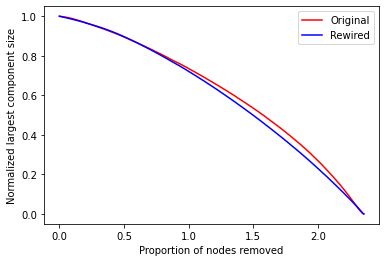

In [11]:
nodes_removed = [i / 1622173 for i in range(num_edges)]
sizes = sizes[::-1]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [20]:
np.average(r_indices)

0.6016941134633331

In [ ]:
np.std(r_indices)

In [21]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(approx_area(sizes), np.inf)

0.0

#### Strongest link (count)

In [12]:
g_cc = get_graph()

In [ ]:
r_indices = []
run_sizes = np.empty((0, num_edges))

for run in range(50):
    gt.random_rewire(g_cc, n_iter=2)
    sizes, _ = gt.edge_percolation(g_cc, get_weakest_links(g_cc, prop='c1'))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'STD: {np.std(r_indices)}')

g_cc = get_graph()
sizes, _ = gt.edge_percolation(g_cc, get_weakest_links(g_cc, prop='c1'))

In [ ]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

In [ ]:
nodes_removed = [i / 1622173 for i in range(num_edges)]
sizes = sizes[::-1]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [24]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(approx_area(sizes), np.inf)

0.0

#### Weakest link (total)

In [66]:
g_cc = get_graph()

In [ ]:
r_indices = []
run_sizes = np.empty((0, num_edges))

for run in range(50):
    gt.random_rewire(g_cc, n_iter=2)
    sizes, _ = gt.edge_percolation(g_cc, get_weakest_links(g_cc, prop='c0', reverse=True))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'STD: {np.std(r_indices)}')

g_cc = get_graph()
sizes, _ = gt.edge_percolation(g_cc, get_weakest_links(g_cc, prop='c0', reverse=True))

In [ ]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

In [ ]:
nodes_removed = [i / 1622173 for i in range(num_edges)]
sizes = sizes[::-1]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [27]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(approx_area(sizes), np.inf)

0.0

#### Weakest link (count)

In [69]:
g_cc = get_graph()

In [ ]:
r_indices = []
run_sizes = np.empty((0, num_edges))

for run in range(50):
    gt.random_rewire(g_cc, n_iter=2)
    sizes, _ = gt.edge_percolation(g_cc, get_weakest_links(g_cc, prop='c1', reverse=True))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'STD: {np.std(r_indices)}')

g_cc = get_graph()
sizes, _ = gt.edge_percolation(g_cc, get_weakest_links(g_cc, prop='c1', reverse=True))

In [ ]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

In [ ]:
nodes_removed = [i / 1622173 for i in range(num_edges)]
sizes = sizes[::-1]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [30]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(0.5145684420692376, np.inf)

0.0

#### Links with weight closest to average (total)

In [9]:
g_cc = get_graph()

In [7]:
def get_average_links(target, prop='c0', reverse=False):
    weights = [int(w) for s, t, w in g_cc.iter_edges([g_cc.edge_properties[prop]])]
    avg_weight = sum(weights) / len(weights)
    del weights
    edges = [(s, t, int(w)) for s, t, w in g_cc.iter_edges([g_cc.edge_properties[prop]])]
    edges = sorted(edges, key=lambda e: abs(e[2] - avg_weight), reverse=reverse)
    return [(s, t) for s, t, w in edges]

In [ ]:
r_indices = []
run_sizes = np.empty((0, num_edges))

for run in range(50):
    gt.random_rewire(g_cc, n_iter=2)
    sizes, _ = gt.edge_percolation(g_cc, get_average_links(g_cc, prop='c0', reverse=True))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'STD: {np.std(r_indices)}')

g_cc = get_graph()
sizes, _ = gt.edge_percolation(g_cc, get_average_links(g_cc, prop='c0', reverse=True))

In [ ]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

In [ ]:
nodes_removed = [i / 1622173 for i in range(num_edges)]
sizes = sizes[::-1]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [34]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(approx_area(sizes), np.inf)

0.0

#### Links with weight closest to average (count)

In [83]:
g_cc = get_graph()

In [ ]:
r_indices = []
run_sizes = np.empty((0, num_edges))

for run in range(50):
    gt.random_rewire(g_cc, n_iter=2)
    sizes, _ = gt.edge_percolation(g_cc, get_average_links(g_cc, prop='c1', reverse=True))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'STD: {np.std(r_indices)}')

g_cc = get_graph()
sizes, _ = gt.edge_percolation(g_cc, get_average_links(g_cc, prop='c1', reverse=True))

In [ ]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

In [ ]:
nodes_removed = [i / 1622173 for i in range(num_edges)]
sizes = sizes[::-1]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [37]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(approx_area(sizes), np.inf)

0.0

#### Links with weight furthest from average (total)

In [24]:
g_cc = get_graph()

In [8]:
num_edges = len(get_average_links(g_cc, prop='c0', reverse=False))

In [ ]:
r_indices = []
run_sizes = np.empty((0, num_edges))

for run in range(50):
    gt.random_rewire(g_cc, n_iter=2)
    sizes, _ = gt.edge_percolation(g_cc, get_average_links(g_cc, prop='c0', reverse=False))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'STD: {np.std(r_indices)}')

g_cc = get_graph()
sizes, _ = gt.edge_percolation(g_cc, get_average_links(g_cc, prop='c0', reverse=False))

In [ ]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

In [ ]:
nodes_removed = [i / 1622173 for i in range(num_edges)]
sizes = sizes[::-1]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [40]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(approx_area(sizes), np.inf)

0.0

#### Links with weight furthest from average (count)

In [4]:
g_cc = get_graph()

In [ ]:
r_indices = []
run_sizes = np.empty((0, num_edges))

for run in range(50):
    gt.random_rewire(g_cc, n_iter=2)
    sizes, _ = gt.edge_percolation(g_cc, get_average_links(g_cc, prop='c1', reverse=False))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'STD: {np.std(r_indices)}')

g_cc = get_graph()
sizes, _ = gt.edge_percolation(g_cc, get_average_links(g_cc, prop='c1', reverse=False))

In [ ]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

In [ ]:
nodes_removed = [i / 1622173 for i in range(num_edges)]
sizes = sizes[::-1]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [ ]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(approx_area(sizes), np.inf)

#### Similarity and Dissimilarity Attack

In [6]:
g_cc = get_graph()

In [17]:
def get_similar_links(target, beta=0.001, reverse=False):
    return sorted([(e.source(), e.target()) for e in target.edges()],
                   key=lambda e: np.exp(-1 * beta * np.power((e[0].in_degree() + e[0].out_degree()) - (e[1].out_degree() + e[1].in_degree()), 2)),
                   reverse=reverse)

In [8]:
num_edges = len(get_similar_links(g_cc))

In [ ]:
r_indices = []
run_sizes = np.empty((0, num_edges))

for run in range(50):
    gt.random_rewire(g_cc, n_iter=2)
    sizes, _ = gt.edge_percolation(g_cc, get_similar_links(g_cc, reverse=False))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'STD: {np.std(r_indices)}')

g_cc = get_graph()
sizes, _ = gt.edge_percolation(g_cc, get_similar_links(g_cc, reverse=False))

In [ ]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

In [ ]:
nodes_removed = [i / 1622173 for i in range(num_edges)]
sizes = sizes[::-1]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [ ]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(approx_area(sizes), np.inf)

In [18]:
g_cc = get_graph()

In [ ]:
r_indices = []
run_sizes = np.empty((0, num_edges))

for run in range(50):
    gt.random_rewire(g_cc, n_iter=2)
    sizes, _ = gt.edge_percolation(g_cc, get_similar_links(g_cc, reverse=True))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
print(f'AVG REWIRED R-INDEX: {np.average(r_indices)}')
print(f'STD: {np.std(r_indices)}')

g_cc = get_graph()
sizes, _ = gt.edge_percolation(g_cc, get_similar_links(g_cc, reverse=True))

In [ ]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

In [ ]:
nodes_removed = [i / 1622173 for i in range(num_edges)]
sizes = sizes[::-1]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [ ]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(approx_area(sizes), np.inf)

In [35]:
gt.assortativity(g_cc, 'total')

(-0.01971995992878063, 2.8384251858250297e-05)

In [43]:
gt.global_clustering(g_cc)

(0.0014765077829610768, 0.0005058835537482355)

In [48]:
gt.random_rewire(g_cc)

76812

In [41]:
gt.assortativity(g_cc, 'total')

(-0.00023743823470584867, 6.459676178374083e-05)

In [47]:
gt.global_clustering(g_cc)

(0.005084438677866588, 0.0014912761370327887)

In [49]:
gt.global_clustering(g_cc)

(0.005106915219421393, 0.0014949938851700295)

#### Centrality Attack (Total)

In [49]:
g_cc = get_graph()

In [ ]:
r_indices = []
run_sizes = np.empty((0, num_edges))

for run in range(50):
    gt.random_rewire(g_cc, n_iter=2)
    sizes, _ = gt.edge_percolation(g_cc, sorted([(e.source(), e.target()) for e in g_cc.edges()], reverse=True,
                                            key=lambda e: (e[0].out_degree() + e[0].in_degree()) * (e[1].out_degree() + e[1].in_degree())))
    max_size_rewire = len(list(gt.extract_largest_component(g_cc, directed=False).get_vertices()))
    sizes = [size / max_size_rewire for size in sizes]
    run_sizes = np.vstack((run_sizes, sizes))
    r_indices.append(approx_area(sizes))
    
g_cc = get_graph()
sizes, _ = gt.edge_percolation(g_cc, sorted([(e.source(), e.target()) for e in g_cc.edges()], reverse=True,
                                            key=lambda e: (e[0].out_degree() + e[0].in_degree()) * (e[1].out_degree() + e[1].in_degree())))

In [ ]:
size_avg = np.average(run_sizes, axis=0)
size_std = np.std(run_sizes, axis=0)

In [ ]:
nodes_removed = [i / 1622173 for i in range(num_edges)]
sizes = sizes[::-1]
sizes = [size / 1622173 for size in sizes]
size_avg = size_avg[::-1]
size_std = size_std[::-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(nodes_removed, sizes, color='r', label='Original')
ax.plot(nodes_removed, size_avg, color='b', label='Rewired')
ax.fill_between(nodes_removed, size_avg + 2 * size_std, size_avg - 2 * size_std, facecolor='blue', alpha=0.5)
ax.legend(loc="upper right")
ax.set_xlabel('Proportion of nodes removed')
ax.set_ylabel('Normalized largest component size')
plt.show()

In [ ]:
kernel = scipy.stats.gaussian_kde(r_indices)
kernel.integrate_box_1d(approx_area(sizes), np.inf)

Hypothesis testing for properties

Assortativity

In [76]:
g_cc = get_graph()
gt.assortativity(g_cc, 'total')[0]

-0.023388855151779107

In [77]:
assorts = []
for run in range(100):
    if run % 10 == 0:
        print(f'RUN: {run}')
    gt.random_rewire(g_cc, n_iter=2)
    assorts.append(gt.assortativity(g_cc, 'total')[0])

RUN: 0
RUN: 10
RUN: 20
RUN: 30
RUN: 40
RUN: 50
RUN: 60
RUN: 70
RUN: 80
RUN: 90


In [79]:
np.std(assorts)

7.000047451297368e-05

In [78]:
np.average(assorts)

-0.000330450046165295

In [21]:
from scipy.stats import anderson

stat = anderson(assorts)
for i in range(len(stat.significance_level)):
    sl, cv = stat.significance_level[i], stat.critical_values[i]
    if stat.statistic < cv:
        print(f'Probably gaussian at the {sl}% level')
    else:
        print(f'Probably not gaussian at the {sl}% level')

Probably not gaussian at the 15.0% level
Probably not gaussian at the 10.0% level
Probably gaussian at the 5.0% level
Probably gaussian at the 2.5% level
Probably gaussian at the 1.0% level


In [22]:
kernel = scipy.stats.gaussian_kde(assorts)
kernel.integrate_box_1d(-np.inf, -0.023388855151779107)

0.0

In [18]:
g_cc = get_graph()
gt.assortativity(g_cc, 'in')[0]

-0.014572546470430329

In [19]:
assorts = []
for run in range(100):
    if run % 10 == 0:
        print(f'RUN: {run}')
    gt.random_rewire(g_cc, n_iter=2)
    assorts.append(gt.assortativity(g_cc, 'in')[0])

RUN: 0
RUN: 10
RUN: 20
RUN: 30
RUN: 40
RUN: 50
RUN: 60
RUN: 70
RUN: 80
RUN: 90


In [20]:
np.average(assorts)

-0.00021342293505621058

In [22]:
np.std(assorts)

6.750613165852737e-05

In [21]:
kernel = scipy.stats.gaussian_kde(assorts)
kernel.integrate_box_1d(-np.inf, -0.014572546470430329)

0.0

In [23]:
g_cc = get_graph()
gt.assortativity(g_cc, 'out')[0]

-0.02238997015462126

In [24]:
assorts = []
for run in range(100):
    if run % 10 == 0:
        print(f'RUN: {run}')
    gt.random_rewire(g_cc, n_iter=2)
    assorts.append(gt.assortativity(g_cc, 'out')[0])

RUN: 0
RUN: 10
RUN: 20
RUN: 30
RUN: 40
RUN: 50
RUN: 60
RUN: 70
RUN: 80
RUN: 90


In [25]:
np.average(assorts)

-0.00029526416094943406

In [26]:
np.std(assorts)

7.486313606321895e-05

In [27]:
kernel = scipy.stats.gaussian_kde(assorts)
kernel.integrate_box_1d(-np.inf, -0.02238997015462126)

0.0

Transitivity

In [80]:
g_cc = get_graph()
transitivities = []
for run in range(100):
    if run % 10 == 0:
        print(f'RUN: {run}')
    gt.random_rewire(g_cc, n_iter=2)
    transitivities.append(gt.global_clustering(g_cc)[0])

RUN: 0
RUN: 10
RUN: 20
RUN: 30
RUN: 40
RUN: 50
RUN: 60
RUN: 70
RUN: 80
RUN: 90


In [24]:
np.average(transitivities)

0.004935483726463359

In [81]:
np.std(transitivities)

2.2440497979026384e-05

In [60]:
from scipy.stats import anderson

stat = anderson(transitivities)
for i in range(len(stat.significance_level)):
    sl, cv = stat.significance_level[i], stat.critical_values[i]
    if stat.statistic < cv:
        print(f'Probably gaussian at the {sl}% level')
    else:
        print(f'Probably not gaussian at the {sl}% level')

Probably gaussian at the 15.0% level
Probably gaussian at the 10.0% level
Probably gaussian at the 5.0% level
Probably gaussian at the 2.5% level
Probably gaussian at the 1.0% level


In [42]:
gt.global_clustering(g_cc)

(0.0011743716520413723, 0.0004362938647781204)

In [144]:
from sklearn.neighbors import KernelDensity

X = np.array(transitivities).reshape((100, 1))
bandwidth = 1.06 * (np.std(transitivities)) * (100 ** (-1 / 5))
kde = KernelDensity(bandwidth=bandwidth).fit(X)

In [90]:
g_cc = get_graph()

In [130]:
kernel = scipy.stats.gaussian_kde(transitivities)

In [129]:
kernel.integrate_box_1d(-np.inf, 0.0011743716520413723)

0.0

In [55]:
DATASET_PATH = 'rabobank_data_agg.csv'
graph_df = pd.read_csv(DATASET_PATH)

In [58]:
scipy.stats.spearmanr(graph_df['count'], graph_df['total'])

SpearmanrResult(correlation=0.7299197411159788, pvalue=0.0)

In [23]:
val, vecs = eigs(gt.hashimoto(g_cc, compact=True), k=1, which='LR')
1 / val[0].real

0.0035516999891226277

In [ ]:
degrees = G_cc.degree()
degrees = sp.diags([degrees[n] for n in G_cc.nodes()])
adj = nx.adjacency_matrix(G_cc)
I = sp.eye(G_cc.order())
ps_hashimoto = sp.bmat([[adj, degrees - I], [-I, None]])

In [20]:
RUNS = 100
bounds = []

for run in range(RUNS):
    gt.random_rewire(g_cc, n_iter=2)
    degrees = sp.diags([v.out_degree() + v.in_degree() for v in g_cc.vertices()])
    adj = gt.adjacency(g_cc)
    I = sp.eye(len(list(g_cc.vertices())))
    ps_hashimoto = sp.bmat([[adj, degrees - I], [-I, None]])
    val, vecs = eigs(ps_hashimoto, k=1, which='LR')
    bounds.append(1 / val[0].real)

In [19]:
val, vecs = eigs(ps_hashimoto, k=1, which='LR')
1 / val[0].real

0.01046916993697828

In [21]:
np.average(bounds)

0.01266432063664994

In [22]:
np.std(bounds)

2.9215833961578398e-05